<h1 align="center">UST, Zewail City</h1>
<h2 align="center">CIE 555 (Spring 2021)</h2>
<h2 align="center">Lab 3 : Classification Neural Networks in Keras and PyTorch</h2>
<h2 align="center">Aya Elzahy</h2>


#Lab Objectives: 
* Implement a classification model using neural networks and assess its performance.
* Practice the use and implementation of some of the notions introduced in the lecture including activation functions, cost functions and network architecture.
* Introduce pytorch library and understand some of its key functionalities.

#Import statements 

In [ ]:
import numpy as np
from keras.datasets import mnist
from keras.utils import to_categorical, plot_model
from keras.layers import Dense 
from keras.models import Sequential 
import matplotlib.pyplot as plt

import cv2
import glob
from google.colab.patches import cv2_imshow
%matplotlib inline

from sklearn.model_selection import train_test_split

#Dataset

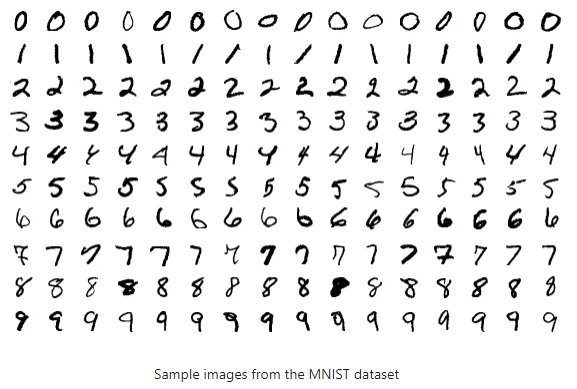

In this lab, we'll use MNIST hand-written digit classification dataset. This is a dataset of 60,000 28x28 grayscale images of the 10 digits, along with a test set of 10,000 images.

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
#load_data() returns a tuple of Numpy arrays: (x_train, y_train), (x_test, y_test).
#arrays of grayscale image data with shapes(num_samples, 28, 28).

print(x_train.shape) 
print(x_test.shape)

(60000, 28, 28)
(10000, 28, 28)


Display random images from the dataset

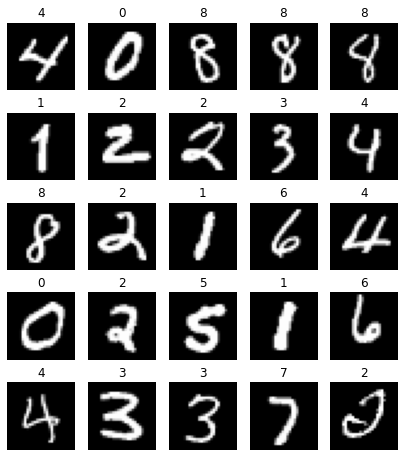

In [ ]:
# sample 25 mnist digits from train dataset
indecies = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indecies]
labels = y_train[indecies]


# plot the 25 mnist digits
plt.figure(figsize=(7,8))
for i in range(len(indecies)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')  #Display data as an image
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

Since we'll use fully connected neural networks, the input data must be a vector. Instead of several 28x28 images, we’ll have several vectors that are all length 784 (28*28=784). 

Then, we scale each pixel value from 0 to 255 to be mapped to a new range from 0.0 to 1.0 (normalization). 

In [ ]:
image_vector_size = 28*28
x_train = x_train.reshape(x_train.shape[0], image_vector_size)
x_train = x_train.astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], image_vector_size)
x_test = x_test.astype('float32') / 255

One hot encoding the labels

In [ ]:
num_classes = len(np.unique(y_train)) #ten unique digits
print("First 2 training lables:\n", y_train[:2])
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)
print("First 2 training lables as one-hot encoded vectors:\n", y_train_ohe[:2])

First 2 training lables:
 [5 0]
First 2 training lables as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


#Keras model

Keras has two ways of defining a model: 

1) Sequential model 

2) Functional API 

##1) Sequential model:

In a sequential model, the output of each layer is the input to the subsequent layer. You need to specify the input shape in the first layer. 

Each type of layer requires the input with a certain number of dimensions. Dense layers require inputs as (batch_size, input_size). 

Keras ignores the first dimension, which is the batch size. Your model should be able to deal with any batch size, so you define only the other dimensions. 

If your input shape has only one dimension, you don't need to give it as a tuple, you give input_dim as a scalar number.

* input_shape=(image_size,) 
* input_dim = image_size

In [ ]:
image_size = 784   #28*28
model = Sequential() 
#Sequential specifies that the model is created sequentially and the output of each layer is input to the next
model.add(Dense(units=32, activation='sigmoid', input_dim=image_size))
#model.add is used to add a layer to our neural network. We need to specify as an argument what type of layer we want. 
#Dense is used to specify a fully connected layer. 
model.add(Dense(units=num_classes, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_21 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


The resulting architecture has 25,450 tunable parameters. From the input layer to the hidden layer there are 784*32 = 25,088 weights.
 
The hidden layer has 32 nodes so there are 32 biases. This brings us to 25,088 + 32 = 25,120 parameters.

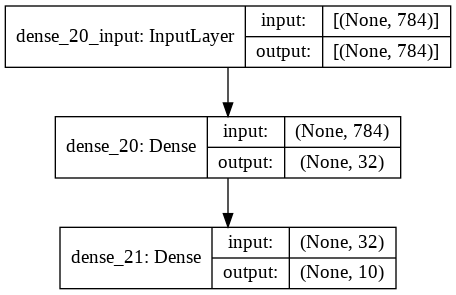

In [ ]:
plot_model(model, to_file='model-mnist.png', show_shapes=True)

**When to use a Sequential model**

A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input and one output.

**A Sequential model is not appropriate when:**

* Your model has multiple inputs or multiple outputs
* Any of your layers has multiple inputs or multiple outputs
* You need to do layer sharing

##2) Functional API:

The Keras functional API is a way to create models that are more flexible than the sequentail API. 

In [ ]:
from keras.models import Model
from keras.layers import * 

#Start defining the input tensor:
input = Input((image_size,))   
#Pass the input to the hidden layer
hidden_layer = Dense(units=32, activation="sigmoid")(input)
#Pass to the output layer    
output_layer= Dense(units=num_classes, activation="softmax")(hidden_layer)   

#define the model's start and end points    
model2= Model(input,output_layer)
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_22 (Dense)             (None, 32)                25120     
_________________________________________________________________
dense_23 (Dense)             (None, 10)                330       
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


##Training

In [ ]:
model.compile(optimizer="sgd", loss='categorical_crossentropy', metrics=['accuracy'])
#Categorical cross entropy computes the crossentropy loss between the labels and predictions.
#Use this crossentropy loss function when there are two or more label classes. 
#We expect labels to be provided in a one_hot representation. 
#If you want to provide labels as integers, use SparseCategoricalCrossentropy loss.
history = model.fit(x_train, y_train_ohe, epochs=20, validation_split=.1)

Epoch 1/20
1688/1688 [==============================] - 3s 1ms/step - loss: 2.0279 - accuracy: 0.4243 - val_loss: 1.1657 - val_accuracy: 0.8073
Epoch 2/20
1688/1688 [==============================] - 2s 1ms/step - loss: 1.0772 - accuracy: 0.7807 - val_loss: 0.7276 - val_accuracy: 0.8632
Epoch 3/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.7412 - accuracy: 0.8347 - val_loss: 0.5543 - val_accuracy: 0.8853
Epoch 4/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.6012 - accuracy: 0.8599 - val_loss: 0.4629 - val_accuracy: 0.8983
Epoch 5/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.5146 - accuracy: 0.8759 - val_loss: 0.4070 - val_accuracy: 0.9035
Epoch 6/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4593 - accuracy: 0.8880 - val_loss: 0.3699 - val_accuracy: 0.9095
Epoch 7/20
1688/1688 [==============================] - 2s 1ms/step - loss: 0.4281 - accuracy: 0.8898 - val_loss: 0.3439 - val_accuracy:

##Learning curves

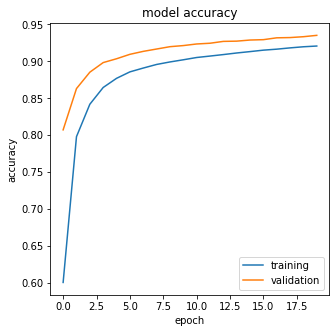

Test loss:  0.2708464562892914
Test accuracy:  0.9228000044822693


In [ ]:
plt.figure(figsize=(5,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

loss, accuracy= model.evaluate(x_test, y_test_ohe, verbose=False)
print('Test loss: ',loss)
print('Test accuracy: ',accuracy)

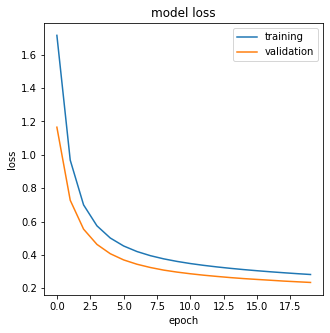

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

##Predict test data

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


9228  classified correctly
772  classified incorrectly


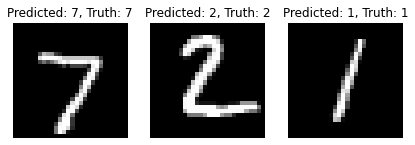

In [ ]:
predicted_classes= model.predict_classes(x_test)

# get and plot some correct and incorrect predictions
correct_indices = np.nonzero(predicted_classes == y_test)[0]  #Return the indices of the elements that are non-zero
incorrect_indices = np.nonzero(predicted_classes != y_test)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


# plot 3 correct predictions
plt.figure(figsize=(7,8))
for i, correct in enumerate(correct_indices[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                        y_test[correct]))
    plt.axis('off')



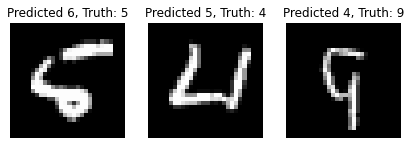

In [ ]:
# plot 3 incorrect predictions
plt.figure(figsize=(7,8))
for i, incorrect in enumerate(incorrect_indices[:3]):
    plt.subplot(1,3,i+1)
    plt.imshow(x_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title(
      "Predicted {}, Truth: {}".format(predicted_classes[incorrect], 
                                       y_test[incorrect]))
    plt.axis('off')

##Choice of activation functions for hidden layers

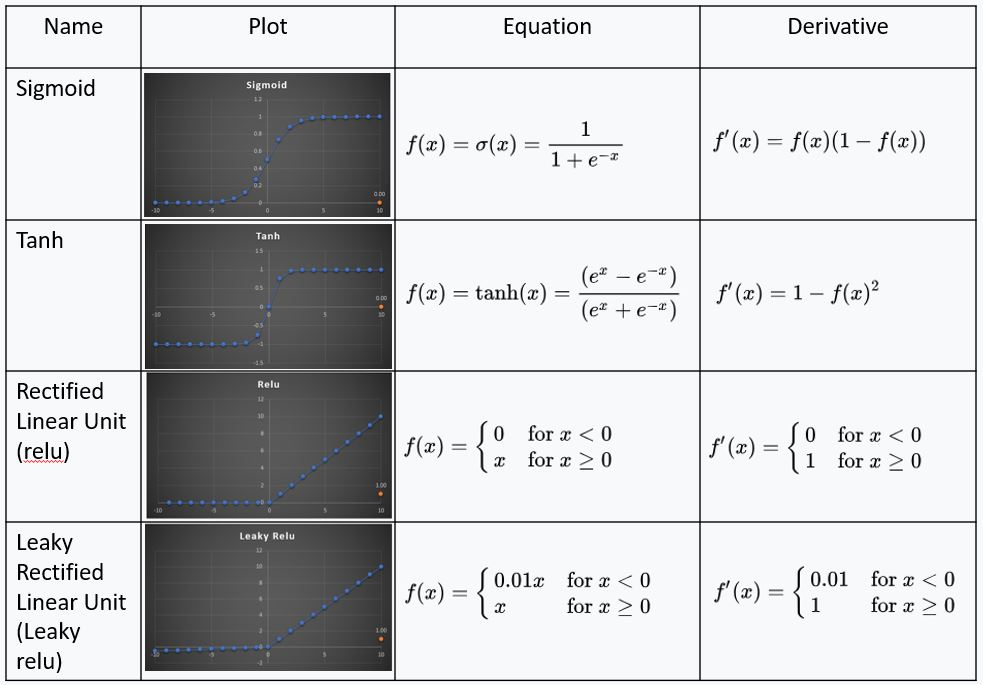
source:https://engmrk.com/activation-function-for-dnn/

**Sigmoid** :<br>

* sigmoidal units saturate across most of their
domain—they saturate to a high value when z is very positive, saturate to a low value when z is very negative, and are only strongly sensitive to their input when
z is near 0.
* The widespread saturation of sigmoidal units can make gradient-based learning very difficult. For this reason, their use as hidden units in feedforward networks is now discouraged. Gradients tend to get smaller and smaller as we keep on moving backward which slows down the learning process since vanishing gradients make it difficult to know which direction the parameters should move to improve the cost function.

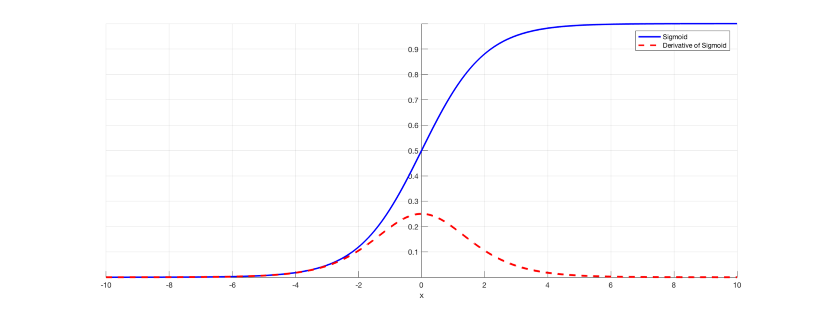

**Tanh** 
* Tanh is usually preferred to sigmoid, but they both suffer from vanishing gradients. 

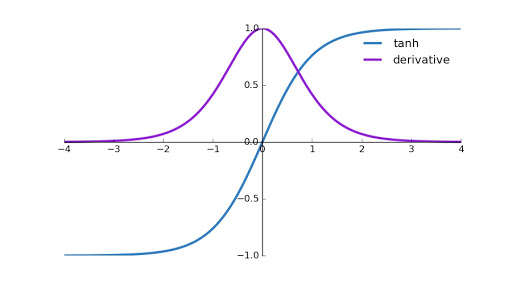

**ReLU**: 

* ReLU activation function, is perhaps the most common function used for hidden layers.

* It is less susceptible to vanishing gradients that prevent deep models from being trained, although it can suffer from other problems like saturated or “dead” units.


* problem:<br>
The Dying ReLU problem—when inputs approach zero, or are negative, the gradient of the function becomes zero, the network cannot perform backpropagation and cannot learn. To overcome this problem, we use ReLU variations such as Leaky ReLU. 

#Task 1 [5 marks]

Use the functions in the following cell to fine tune the model without code repetition. You'll get introduced to automated Keras tuners later, so there's no need to use them in this task. Experiment with different architectures and hidden layer activations and comment on the results. You may need to change the number of interations or the optimizer for a better performance.  

In [ ]:
def create_model(num_h_layers, activation, units): 
  image_size= 28*28
  num_classes= 10
  model = Sequential() 
  model.add(Dense(units=units, activation=activation, input_dim=image_size)) 
  for i in range (num_h_layers-1):
    model.add(Dense(units=units, activation=activation)) 
  model.add(Dense(units=num_classes, activation='softmax'))
  return model 

def train_model(x_train, y_train_ohe, model, optim, loss_func, epochs):
  model.compile(optimizer=optim, loss=loss_func, metrics=['accuracy'])
  history = model.fit(x_train, y_train_ohe, epochs=epochs, validation_split=.1)
  return history

def plot_loss(history): 
  plt.figure(figsize=(5,5))
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training', 'validation'], loc='best')
  plt.show()

Epoch 1/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.3357 - accuracy: 0.1107 - val_loss: 2.2970 - val_accuracy: 0.1057
Epoch 2/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.2945 - accuracy: 0.1230 - val_loss: 2.2885 - val_accuracy: 0.1088
Epoch 3/40
1688/1688 [==============================] - 2s 1ms/step - loss: 2.2871 - accuracy: 0.1409 - val_loss: 2.2775 - val_accuracy: 0.1085
Epoch 4/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.2739 - accuracy: 0.1543 - val_loss: 2.2559 - val_accuracy: 0.2337
Epoch 5/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.2480 - accuracy: 0.2433 - val_loss: 2.2059 - val_accuracy: 0.3655
Epoch 6/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.1844 - accuracy: 0.3925 - val_loss: 2.0683 - val_accuracy: 0.4410
Epoch 7/40
1688/1688 [==============================] - 3s 1ms/step - loss: 2.0087 - accuracy: 0.4501 - val_loss: 1.7567 - val_accuracy:

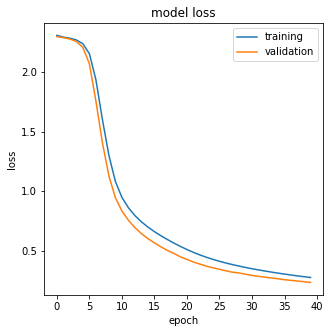

In [ ]:
#Example experiment 
model1= create_model(3,'sigmoid', 32)
history1= train_model(x_train, y_train_ohe, model1, 'sgd', 'categorical_crossentropy', 40)
plot_loss(history1)

Epoch 1/40
1688/1688 [==============================] - 3s 2ms/step - loss: 1.1779 - accuracy: 0.6842 - val_loss: 0.3640 - val_accuracy: 0.9113
Epoch 2/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3869 - accuracy: 0.8973 - val_loss: 0.2632 - val_accuracy: 0.9298
Epoch 3/40
1688/1688 [==============================] - 3s 1ms/step - loss: 0.3009 - accuracy: 0.9167 - val_loss: 0.2185 - val_accuracy: 0.9372
Epoch 4/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2560 - accuracy: 0.9271 - val_loss: 0.1911 - val_accuracy: 0.9463
Epoch 5/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2189 - accuracy: 0.9375 - val_loss: 0.1682 - val_accuracy: 0.9520
Epoch 6/40
1688/1688 [==============================] - 3s 1ms/step - loss: 0.1922 - accuracy: 0.9447 - val_loss: 0.1605 - val_accuracy: 0.9530
Epoch 7/40
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1754 - accuracy: 0.9506 - val_loss: 0.1442 - val_accuracy:

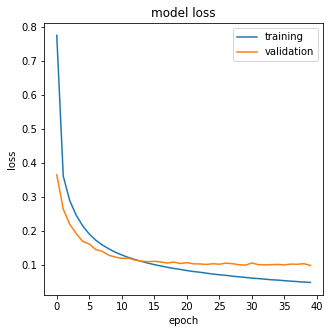

In [ ]:
model2= create_model(3,'tanh', 32)
history1= train_model(x_train, y_train_ohe, model2, 'sgd', 'categorical_crossentropy', 40)
plot_loss(history1)

There's a gap between training and validation losses, but the loss is smaller than the previous one

Epoch 1/40
1688/1688 [==============================] - 3s 1ms/step - loss: 1.4299 - accuracy: 0.5438 - val_loss: 0.3377 - val_accuracy: 0.9045
Epoch 2/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.3649 - accuracy: 0.8930 - val_loss: 0.2562 - val_accuracy: 0.9268
Epoch 3/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2885 - accuracy: 0.9147 - val_loss: 0.2107 - val_accuracy: 0.9375
Epoch 4/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2401 - accuracy: 0.9288 - val_loss: 0.1845 - val_accuracy: 0.9470
Epoch 5/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.2069 - accuracy: 0.9404 - val_loss: 0.1698 - val_accuracy: 0.9518
Epoch 6/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1862 - accuracy: 0.9443 - val_loss: 0.1523 - val_accuracy: 0.9573
Epoch 7/40
1688/1688 [==============================] - 2s 1ms/step - loss: 0.1669 - accuracy: 0.9505 - val_loss: 0.1411 - val_accuracy:

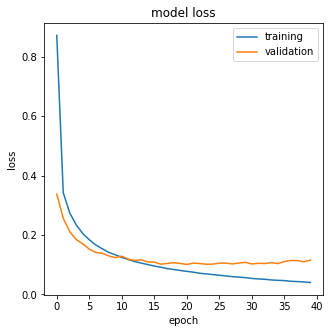

In [ ]:
model3= create_model(3,'relu', 32)
history1= train_model(x_train, y_train_ohe, model3, 'sgd', 'categorical_crossentropy', 40)
plot_loss(history1)

There's a larger gap here, the training loss keeps on decreasing but the validation loss seems to saturate (however, there are fluctuations, the curve is not smooth)

Epoch 1/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.3129 - accuracy: 0.1141 - val_loss: 2.2967 - val_accuracy: 0.1050
Epoch 2/40
1688/1688 [==============================] - 3s 1ms/step - loss: 2.2945 - accuracy: 0.1190 - val_loss: 2.2882 - val_accuracy: 0.1050
Epoch 3/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.2841 - accuracy: 0.1276 - val_loss: 2.2715 - val_accuracy: 0.2598
Epoch 4/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.2644 - accuracy: 0.1958 - val_loss: 2.2268 - val_accuracy: 0.2438
Epoch 5/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.2073 - accuracy: 0.2399 - val_loss: 2.0907 - val_accuracy: 0.2327
Epoch 6/40
1688/1688 [==============================] - 3s 2ms/step - loss: 2.0421 - accuracy: 0.2880 - val_loss: 1.8577 - val_accuracy: 0.3057
Epoch 7/40
1688/1688 [==============================] - 3s 2ms/step - loss: 1.8325 - accuracy: 0.3694 - val_loss: 1.6946 - val_accuracy:

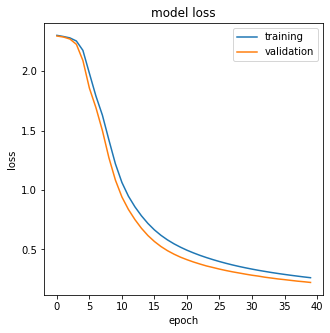

In [ ]:
model4= create_model(3,'sigmoid', 36)
history1= train_model(x_train, y_train_ohe, model, 'sgd', 'categorical_crossentropy', 40)
plot_loss(history1)

Model 2 using tanh activation function, achieved the smallest loss 

Epoch 1/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3023 - accuracy: 0.3463 - val_loss: 0.2327 - val_accuracy: 0.6970
Epoch 2/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2267 - accuracy: 0.6905 - val_loss: 0.1950 - val_accuracy: 0.8088
Epoch 3/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1955 - accuracy: 0.7822 - val_loss: 0.1751 - val_accuracy: 0.8513
Epoch 4/50
1688/1688 [==============================] - 3s 1ms/step - loss: 0.1780 - accuracy: 0.8261 - val_loss: 0.1628 - val_accuracy: 0.8718
Epoch 5/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1675 - accuracy: 0.8395 - val_loss: 0.1545 - val_accuracy: 0.8837
Epoch 6/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1597 - accuracy: 0.8553 - val_loss: 0.1486 - val_accuracy: 0.8937
Epoch 7/50
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1539 - accuracy: 0.8652 - val_loss: 0.1444 - val_accuracy:

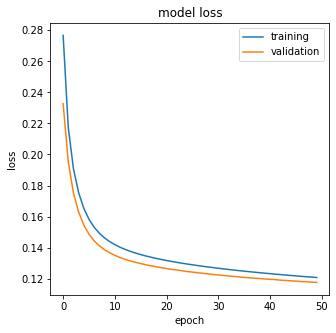

In [ ]:
model5 = create_model(3,'tanh', 32)
history1= train_model(x_train, y_train_ohe, model5, 'SGD', 'Poisson', 50)
plot_loss(history1)

#Task 2 [5 marks][bonus 2 marks]

The objective of this task is to give you a sense of how you can use classification neural networks in your everyday life. The task is as follows: 
1. on a piece of paper, write down in your own handwriting 3 digits that are clear and easy to identify and 3 digits that are unclear and may be confusing. Take a picture of each digit separatly (total of 6 pictures). You can draw them digitally and save the pictures or take screenshots if that is easier. You need to draw bold digits that span the majority of the picture space in order not to be totally distorted when resized later to 28*28. 
2. Read the images as grey scale using cv2.imread("path",0) https://dev-akash.github.io/posts/how-to-convert-color-image-to-grayscale-in-opencv-with-python.html

3. Plot the pictures as grey images in your notebook using plt.imshow with grey scale color map. 

4. Resize the images to the same size of the training data (28*28) using cv2.resize(image,dimensions, interpolation = cv2.INTER_AREA).  

5. You need to apply to the test samples the same transformations you applied to the training data (reshaping and scaling). 

6. Use your fine-tuned model to predict the output for each of the 6 digits.  **[+2]** points for saving the model then using the saved model directly for inference without having to re-train each time you run the notebook (https://keras.io/api/models/model_saving_apis/).  

7. Comment on the results. 
8. If you think this performance is satisfactory, mention some applications on the top of your head that can use this model(i.e OCR). If you don't think that the performance is satisfactory, discuss some possible improvements in terms of model architecture and training dataset.   

In [ ]:
images = [cv2.imread(file, 0) for file in glob.glob("/content/numbers/*.jpg")]
images = [~image for image in images]
#images
image_name = [file.split('/')[-1] for file in glob.glob("/content/numbers/*.jpg")]
labels = [int(name.split('.')[0]) for name in image_name]
labels

[0, 1, 7, 5, 3, 9, 4, 2]

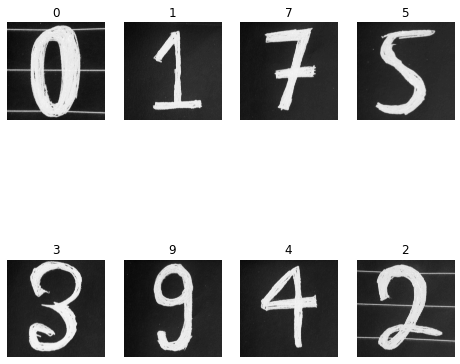

In [ ]:
plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')  #Display data as an image
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

In [ ]:
for i in range(len(images)):
  images[i] = cv2.resize(images[i],(28, 28) , interpolation = cv2.INTER_AREA)

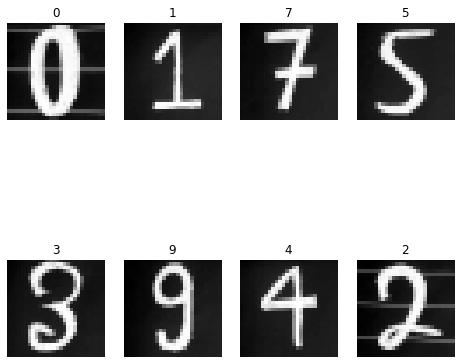

In [ ]:
# plotting the resized image

plt.figure(figsize=(8, 8))
for i in range(len(images)):
    plt.subplot(2, 4, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')  #Display data as an image
    plt.title(labels[i])
    plt.axis('off')
    
plt.show()

In [ ]:
image_vector_size = 28*28
images = [image.reshape(image_vector_size) for image in images]
images = [image.astype('float32') / 255 for image in images]

In [ ]:
images = np.asarray(images)
images.shape

(8, 784)

In [ ]:
predictions1 = model1.predict_classes(images)
predictions2 = model2.predict_classes(images)
predictions3 = model3.predict_classes(images)
predictions4 = model4.predict_classes(images)
predictions5 = model5.predict_classes(images)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
# get and plot some correct and incorrect predictions
correct_indices = np.nonzero(predictions1 == labels)[0]  #Return the indices of the elements that are non-zero
incorrect_indices = np.nonzero(predictions1 != labels)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print("accuracy = {}".format(len(correct_indices)/len(labels)))

1  classified correctly
7  classified incorrectly
accuracy = 0.125


Performance is not so satisfactory, more tuning is needed.

In [ ]:
# get and plot some correct and incorrect predictions
correct_indices = np.nonzero(predictions2 == labels)[0]  #Return the indices of the elements that are non-zero
incorrect_indices = np.nonzero(predictions2 != labels)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print("accuracy = {}".format(len(correct_indices)/len(labels)))

2  classified correctly
6  classified incorrectly
accuracy = 0.25


In [ ]:
# get and plot some correct and incorrect predictions
correct_indices = np.nonzero(predictions3 == labels)[0]  #Return the indices of the elements that are non-zero
incorrect_indices = np.nonzero(predictions3 != labels)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print("accuracy = {}".format(len(correct_indices)/len(labels)))

1  classified correctly
7  classified incorrectly
accuracy = 0.125


In [ ]:
# get and plot some correct and incorrect predictions
correct_indices = np.nonzero(predictions4 == labels)[0]  #Return the indices of the elements that are non-zero
incorrect_indices = np.nonzero(predictions4 != labels)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print("accuracy = {}".format(len(correct_indices)/len(labels)))

1  classified correctly
7  classified incorrectly
accuracy = 0.125


Model 2 gave the highest test accuracy, but not that good. So I will try to further fine tune that model in Model 5.

In [ ]:
# get and plot some correct and incorrect predictions
correct_indices = np.nonzero(predictions5 == labels)[0]  #Return the indices of the elements that are non-zero
incorrect_indices = np.nonzero(predictions5 != labels)[0]
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")
print("accuracy = {}".format(len(correct_indices)/len(labels)))

2  classified correctly
6  classified incorrectly
accuracy = 0.25


In [ ]:
model5.save('Final_model')

INFO:tensorflow:Assets written to: Final_model/assets


The performance doesn't seem to get better by changing the architecture/ loss function/ optimizer. But, there may be a certain combination of hyperparameters that will result in a better performance. I believe that using keras automatic tuning will be the best way to obtain these parameters.

#Part II: Introduction to PyTorch

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

##Tensors

In [ ]:
#Tensors
#Can be initialized from list, tuple, numpy array
x = [[1,2,3],[4,5,6]]
xten = torch.tensor(x, dtype=torch.float32) 
print(xten)
print(xten.size()) #like .shape in tensorflow and numpy
print(xten.size()[1])

##Mathematical operations

In [ ]:
#Mathematical Operations
x = torch.tensor([[-1,2,3],[4,5,6]])
y = torch.tensor([[2,2,2],[2,2,2]])
z = torch.add(x,y) #Addition
print("Addition: ", z)
z = torch.sub(x,y) #Subtraction
print("Subtraction: ", z)
z = torch.mul(x,y) #Element-wise multiplication
print("Element-wise multiplication: ", z)
z = torch.matmul(x,torch.t(y)) #Matrix multiplication
print("Matrix multiplication: ", z)
z = torch.div(x,y) #Element-wise division
print("Element-wise division: ", z)
z = torch.pow(x,y)
print("Power: ", z)

##Autograd

Like Tensorflow, Torch provides a module, autograd, for automatically calculating the gradients of tensors. 

We can use it to calculate the gradients in backpropagation. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way.

To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set *requires_grad = True* on a tensor. You can do this at creation with the *requires_grad* keyword, or at any time with *x.requires_grad_(True)*.

You can turn off gradients for a block of code with the *torch.no_grad()* 

In [ ]:
x = torch.zeros(1, requires_grad=True)
 
with torch.no_grad():
   y = x * 2
y.requires_grad


The gradients are computed with respect to some variable z with *z.backward()*. This does a backward pass through the operations that created z.

In [ ]:
x = torch.randn(2,2, requires_grad=True)
print(x)

In [ ]:
y = x**2
print(y)

In [ ]:
## grad_fn shows the function that generated this variable
print(y.grad_fn)

The autograd module keeps track of these operations and knows how to calculate the gradient for each one. In this way, it's able to calculate the gradients for a chain of operations, with respect to any one tensor. Let's reduce the tensor y to a scalar value, the mean.



In [ ]:
z = y.mean()
print(z)

In [ ]:
print(x.grad)


To calculate the gradients, you need to run the .backward method on a Variable, z  for example. This will calculate the gradient for z with respect to x
image.png

In [ ]:
z.backward()
print(x.grad)
print(x/2)



When we create a network with PyTorch, all of the parameters are initialized with requires_grad = True. This means that when we calculate the loss and call loss.backward(), the gradients for the parameters are calculated. These gradients are used to update the weights with gradient descent.

##Converting input data to tensors

Converting numpy arrays to Torch tensors

In [ ]:
x_train_t = torch.tensor(x_train, requires_grad = False, dtype=torch.float)
y_train_t = torch.tensor(y_train, requires_grad = False, dtype=torch.long) #type long for the cross entropy loss
x_test_t = torch.tensor(x_test, requires_grad = False, dtype=torch.float)
y_test_t = torch.tensor(y_test, requires_grad = False, dtype=torch.long)

##Building the neural network model

Through the nn module, PyTorch provides losses such as the cross-entropy loss (nn.CrossEntropyLoss). 

With a classification problem such as MNIST, we're using the softmax function to predict class probabilities. With a softmax output, you want to use cross-entropy as the loss. To actually calculate the loss, you first define the criterion then pass in the output of your network and the correct labels.

Something really important to note here. Looking at the documentation for nn.CrossEntropyLoss,

This criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.

The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function.

In [ ]:
import tensorflow.keras.backend as K

y_true= np.array([3])
y_true_ohe = np.array([[0, 0, 0, 1]])
y_pred = np.array([[0.1, 0.2, 0.3, 0.4]])

print("Keras", K.categorical_crossentropy(K.constant(y_true_ohe), K.softmax(K.constant(y_pred))))
print("PyTorch", nn.CrossEntropyLoss()(torch.tensor(y_pred).float(), torch.tensor(y_true)))

In [ ]:
image_size = 784 # 28*28
num_classes=10
hidden_units=32

#Build your model 
model= nn.Sequential(
    nn.Linear(image_size,hidden_units), ###Linear layer applies x*W.T+b
    nn.Sigmoid(),
    nn.Linear(hidden_units,num_classes))
print(model)

criterion= nn.CrossEntropyLoss() 
#For nn. CrossEntropyLoss the target has to be a single number from the interval [0, #classes] not one-hot encoded.

#Define your optimization module
#To construct an Optimizer you have to give it an iterable containing the parameters to optimize.
#Then, you can specify optimizer-specific options such as the learning rate
optimizer= torch.optim.SGD(model.parameters(), lr=0.8) 


In [ ]:
for epoch in range(30): 
  y_pred = model(x_train_t)
  loss = criterion(y_pred, y_train_t)
  optimizer.zero_grad()    #Delete the accumulated gradient
  loss.backward()  
  optimizer.step()         #parameter update
  print("Epoch: ", epoch, " Loss: ", loss.item())

#References 
https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

https://keras.io/guides/functional_api/

https://keras.io/guides/sequential_model/

https://pytorch.org/docs/stable/optim.html 

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html

https://pytorch.org/docs/stable/nn.html 

https://keras.io/api/losses/probabilistic_losses/ 

https://medium.com/tebs-lab/how-to-classify-mnist-digits-with-different-neural-network-architectures-39c75a0f03e3 

https://victorzhou.com/blog/keras-neural-network-tutorial/

https://www.kaggle.com/prashant111/mnist-deep-neural-network-with-keras

https://nextjournal.com/gkoehler/digit-recognition-with-keras 

https://github.com/gokriznastic/pytorch-udacity-nanodegree/blob/master/2.%20Neural%20Networks/L7%20intro-to-pytorch/Part%203%20-%20Training%20Neural%20Networks.ipynb

https://towardsdatascience.com/building-our-first-neural-network-in-keras-bdc8abbc17f5#:~:text=Keras%20is%20a%20simple%20tool,20%20and%204%20dimensions%20respectively.